In [1]:
import os
import time
import warnings
import numpy as np
import random as rnd
import pandas as pd
from collections import defaultdict

# Librería Genética
from deap import base, creator, tools, algorithms

from sklearn.utils import shuffle
# Subfunciones de estimadores
from sklearn.base import clone
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/base.py][30]
from sklearn.base import is_classifier
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/base.py][535]
from sklearn.model_selection._validation import _fit_and_score
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_validation.py][346]
from sklearn.model_selection._search import BaseSearchCV
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py][386]
from sklearn.model_selection._search import check_cv
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_split.py][1866]
from sklearn.model_selection._search import _check_param_grid
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py][343]
from sklearn.metrics.scorer import check_scoring
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/metrics/scorer.py][250]
from sklearn.utils.validation import _num_samples
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/validation.py][105]
from sklearn.utils.validation import indexable
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/validation.py][208]
from multiprocessing import Pool, Manager, cpu_count

# Selección para estimadores
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metricas para estimadores
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# Estimadores
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer

#Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

#Ensembles algorithms
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
def set_config():
    top_conf = {}
    top_conf['LogisticRegression']	=	np.array([4, 1, 2, 3, 1])-1    
    top_conf['LinearDiscriminantAnalysis']	=	np.array([6, 1, 3, 3, 5])-1
    top_conf['GaussianNB']	=	np.array([4, 1, 2, 6, 1])-1
    top_conf['MLPClassifier']	=	np.array([4, 1, 4, 6, 1])-1
    top_conf['SVC']	=	np.array([6, 6, 3, 3, 5])-1 #3
    top_conf['DecisionTreeClassifier']	=	np.array([6, 1, 3, 3, 5])-1 #2
    top_conf['KNeighborsClassifier']	=	np.array([6, 1, 3, 6, 1])-1
    top_conf['RandomForestClassifier']	=	np.array([6, 1, 3, 3, 5])-1
    top_conf['ExtraTreesClassifier']	=	np.array([6, 1, 3, 3, 5])-1
    top_conf['GradientBoostingClassifier']	=	np.array([6, 1, 3, 3, 5])-1
    top_conf['AdaBoostClassifier']	=	np.array([6, 1, 3, 3, 1])-1#11   np.array([6, 1, 3, 3, 1])-1#6
    top_conf['VotingClassifier']	=	np.array([6, 1, 3, 3, 5])-1
    return top_conf
    
def set_models():
    rs = 1
    models = []
    models.append(('LogisticRegression', LogisticRegression()))
    # LDA : Warning(Variables are collinear)
    models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))    
    models.append(('GaussianNB', GaussianNB()))
    models.append(('MLPClassifier', MLPClassifier()))
    models.append(('SVC', SVC(random_state=rs)))
    models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state=rs)))
    models.append(('KNeighborsClassifier', KNeighborsClassifier()))
    
    models.append(('RandomForestClassifier', RandomForestClassifier(random_state=rs)))
    # Bagging and Boosting
    # models.append(('ExtraTreesClassifier', ExtraTreesClassifier(n_estimators=150)))
    models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state=rs)))
    
    # models.append(('AdaBoostClassifier', AdaBoostClassifier(DecisionTreeClassifier())))
    
    models.append(('GradientBoostingClassifier',GradientBoostingClassifier(random_state=rs)))
    models.append(('AdaBoostClassifier', AdaBoostClassifier(DecisionTreeClassifier(random_state=rs),
                                                            random_state=rs)))
    # models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
    # Voting
    estimators = []
    estimators.append(("Voting_GradientBoostingClassifier", GradientBoostingClassifier(random_state=rs)))
    estimators.append(("Voting_ExtraTreesClassifier", ExtraTreesClassifier(random_state=rs)))
    voting = VotingClassifier(estimators)
    models.append(('VotingClassifier', voting))
    return models

test_size = 0.2
num_folds = 10
seed = 7
frecuencias = []
names_ = ['Be01', 'Be02', 'Be03', 'Be04', 'Be05', 'Sector']

frecuencias.append(pd.read_csv('sinFiltro/Tx_0x01'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x02'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x03'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x04'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x05'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x06'))#, names=names_))
"""
frecuencias.append(pd.read_csv('Filtrado/LocalizationNew_Tx1.csv', names=names_))
frecuencias.append(pd.read_csv('Filtrado/LocalizationNew_Tx2.csv', names=names_))
frecuencias.append(pd.read_csv('Filtrado/LocalizationNew_Tx3.csv', names=names_))
frecuencias.append(pd.read_csv('Filtrado/LocalizationNew_Tx4.csv', names=names_))
frecuencias.append(pd.read_csv('Filtrado/LocalizationNew_Tx5.csv', names=names_))
frecuencias.append(pd.read_csv('Filtrado/LocalizationNew_Tx6.csv', names=names_))
"""
num_jobs=cpu_count()
#estimadores = set_models()
#configuracion = set_models()
#salida = {}

In [3]:
# find distance error al 0.2%
def distance_error(estimator, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 7)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    # coord pred
    x1 = np.int32((y_pred + 2) % 3)
    y1 = np.int32((y_pred - 1) / 3)
    # coord real
    x2 = np.int32((y_test + 2) % 3)
    y2 = np.int32((y_test - 1) / 3)
    # pasar variacion a distancias metros
    vx = np.abs(x1 - x2)*1.5
    vy = np.abs(y1 - y2)*1.5
    #vx = vx*0.5 + (vx-1)*(vx>0)
    #vy = vy*0.5 + (vy-1)*(vy>0)
    # pitagoras
    err_distance = np.sqrt(vx*vx + vy*vy)
    return err_distance

#def _createDataset(frecuencias, values, seed = 7):
def _createDataset(frecuencias, values):
    from sklearn.utils import shuffle as shuff
    # crear dataset
    names_ = frecuencias[0].columns.values
    seed = 7
    # reestructuracion
    salida_final = pd.DataFrame(columns=names_)
    for sec in range(1,16):
        dataset = pd.DataFrame(columns=names_)
        corte = min([frecuencias[i][frecuencias[i]['Sector']==sec].shape[0] for i in values])
        #l = [frecuencias[i][frecuencias[i]['Sector']==sec].shape[0] for i in values]
        #corte = max(l)
        #tx=l.index(max(l))
        tx = 0
        dataset[names_[tx]] = dataset[names_[tx]].append(frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx]])
        dataset = dataset.reset_index(drop=True)
        for tx in range(1,5):
            dataset[names_[tx]] = frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx]].reset_index(drop=True)
        dataset[names_[tx+1]] = frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx+1]].reset_index(drop=True)
        # join parts
        salida_final = salida_final.append(dataset)
    # shuffle dataset
    salida_final = shuff(salida_final, random_state=seed).reset_index(drop=True)
    salida_final = salida_final.apply(pd.to_numeric)
    # dataframe to X,y 
    X = salida_final[names_[:-1]]
    y = salida_final[names_[-1]]
    return X,y

# The problem to optimize
def getAccuracy( frecuencias, individual, estimator, score_cache, resultados ):
	X,y = _createDataset(frecuencias, individual)
	score = 0
	scorer = "accuracy"
	name = str(estimator).split('(')[0]
	paramkey = name+str(np.int32(individual)+1)
	if paramkey in score_cache:
		score = score_cache[paramkey]
	else:
		print("Modeling ....",name)
		kfold = KFold(n_splits=10, shuffle=False)
		cv_results = cross_val_score(estimator, X, y, cv=kfold, scoring=scorer)
		#print(name,"  ",paramkey,"   ")
		#print(len(X),"  ",len(y),"   ", kfold)
		score = cv_results.mean()
		desv = cv_results.std()
		error = distance_error(estimator, X, y)
		score_cache[paramkey] = score
		dict_result = {'Modelo': name, 'Configuracion':np.int32(individual)+1, 'values': cv_results, 'Accuracy': score, 'stdAccuracy': desv, 'errorMetrico': np.mean(error), 'error': error }
		resultados.append(dict_result)
	return score

In [8]:
estimadores = set_models()
configuraciones = set_config()
score_cache = {}
resultados = []
lista_resultados = []
for name,model in estimadores:
    values = configuraciones[name]
    getAccuracy(frecuencias, values, model, score_cache, resultados)
    #lista_resultados = lista_resultados + list(a.resultados)
    #lista_resultados.append(b)

Modeling .... LogisticRegression
Modeling .... LinearDiscriminantAnalysis
Modeling .... GaussianNB
Modeling .... MLPClassifier
Modeling .... SVC
Modeling .... DecisionTreeClassifier
Modeling .... KNeighborsClassifier
Modeling .... RandomForestClassifier
Modeling .... ExtraTreesClassifier
Modeling .... GradientBoostingClassifier
Modeling .... AdaBoostClassifier
Modeling .... VotingClassifier


##  Mejores Configuraciones por Modelo

In [9]:
topDf = pd.DataFrame(resultados)
display(topDf[['Modelo','Configuracion','Accuracy','stdAccuracy','errorMetrico']])

,Modelo,Configuracion,Accuracy,stdAccuracy,errorMetrico
0,LogisticRegression,"[4, 1, 2, 3, 1]",0.708543,0.025945,0.647290
1,LinearDiscriminantAnalysis,"[6, 1, 3, 3, 5]",0.771807,0.020370,0.486200
2,GaussianNB,"[4, 1, 2, 6, 1]",0.860133,0.017097,0.288983
3,MLPClassifier,"[4, 1, 4, 6, 1]",0.698626,0.020986,0.711882
4,SVC,"[6, 6, 3, 3, 5]",0.829563,0.017179,0.511966
5,DecisionTreeClassifier,"[6, 1, 3, 3, 5]",0.852578,0.015386,0.282129
6,KNeighborsClassifier,"[6, 1, 3, 6, 1]",0.877780,0.015037,0.264383
7,RandomForestClassifier,"[6, 1, 3, 3, 5]",0.898412,0.007043,0.227890
8,ExtraTreesClassifier,"[6, 1, 3, 3, 5]",0.892472,0.013311,0.196575
9,GradientBoostingClassifier,"[6, 1, 3, 3, 5]",0.914520,0.008447,0.185316


In [23]:
def rename_order(dataframe_plot):
    previos = ['LogisticRegression', 'LinearDiscriminantAnalysis', 'GaussianNB', 'MLPClassifier', 
               'SVC', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'RandomForestClassifier', 
               'ExtraTreesClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'VotingClassifier']
    nuevos = ['LoR', 'LDA', 'GNB', 'MLP', 'SVC', 'DT', 'k-NN', 'RF', 'ET', 'GBM', 'AB', 'VC']
    num_models = len(nuevos)
    dataframe_plot = dataframe_plot[['Modelo', 'Configuracion', 'Accuracy', 'errorMetrico', 'values', 'error']]
    for i in range(num_models):
        dataframe_plot['Modelo'] = dataframe_plot['Modelo'].str.replace(previos[i], nuevos[i])
        #df['Modelo'] = df['Modelo'].str.replace('LinearDiscriminantAnalysis','LDA')
    sorterIndex = dict(zip(nuevos,range(num_models)))
    #test
    dataframe_plot['Model_Rank'] = dataframe_plot['Modelo'].map(sorterIndex)
    dataframe_plot = dataframe_plot.sort_values(['Model_Rank'],ascending=True).reset_index(drop=True)[dataframe_plot.columns[:-1]]
    return dataframe_plot

#dataframe_plot = topDf
def column_boxplot(dataframe_plot, column_plot, filename, box_bool=False):
    %pylab inline
    pylab.rcParams['figure.figsize'] = (14, 8)
    dataframe_plot = rename_order(dataframe_plot)
    nuevos = list(rename_order(topDf)['Modelo'])
    num_models = len(dataframe_plot)
    if column_plot == 'values':
        y_label = 'Score'
        x_label = 'Model'
    else:
        y_label = 'Error (m)'
        x_label = 'Model Evaluated'
    lista_plot = []
    for i in range(num_models):
        num_splits = len(list(dataframe_plot[column_plot])[i])
        for j in range(num_splits):
            d = {x_label:nuevos[i], y_label:dataframe_plot[column_plot][i][j]}
            lista_plot.append(d)
    #pd.DataFrame(lista_plot)
    sns.set_style("whitegrid")
    if column_plot == 'values':
        medians = np.round(list(dataframe_plot['Accuracy']),3)
        ax_plot = sns.boxplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
        tope = 1
        var_tope = 0.02
    else:
        #ax_plot = sns.barplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
        medians = np.round(list(dataframe_plot['errorMetrico']),3)
        if box_bool==True:
            ax_plot = sns.boxplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
            tope = 7
            var_tope = 0.2
        else:
            ax_plot = sns.barplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
            tope = 2
            var_tope = 0.1
    plt.format='eps'
    #
    import matplotlib as mplt
    ax_plot.set_xlabel(x_label,fontsize=18)
    ax_plot.set_ylabel(y_label,fontsize=18)
    mplt.rc('xtick', labelsize=15) 
    mplt.rc('ytick', labelsize=15)
    #
    median_labels = [str(s) for s in medians]
    pos = range(num_models)
    for tick,label in zip(pos,ax_plot.get_xticklabels()):
        ax_plot.text(pos[tick], tope-var_tope, median_labels[tick], 
                horizontalalignment='center', color='black', fontsize=15) #, weight='semibold'
    axes = plt.gca()
    if column_plot == 'values':
        axes.set_ylim([0.4, tope])
    else:
        axes.set_ylim([-0.1, tope])
    plt.savefig(filename + ".eps", bbox_inches='tight')    
    plt.show()


##  Boxplot Accuracy por Modelo

Populating the interactive namespace from numpy and matplotlib


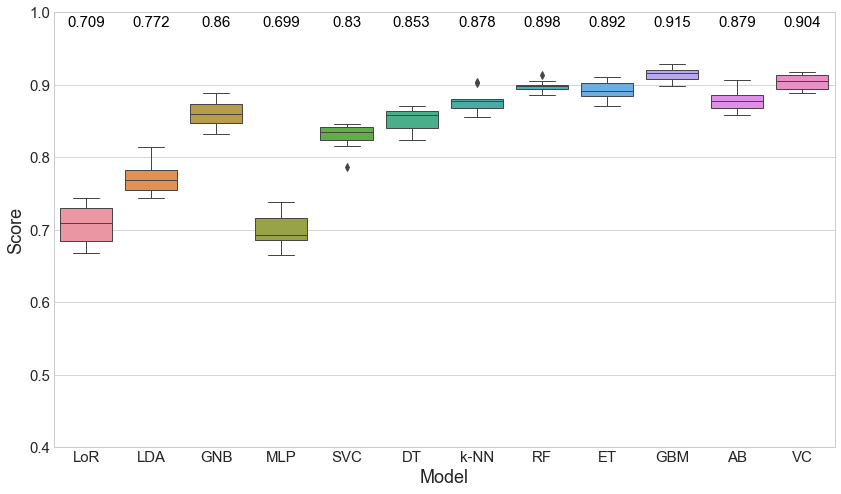

In [20]:
column_boxplot(topDf, 'values', 'acc_results')

##  Boxplot Error por Modelo

Populating the interactive namespace from numpy and matplotlib


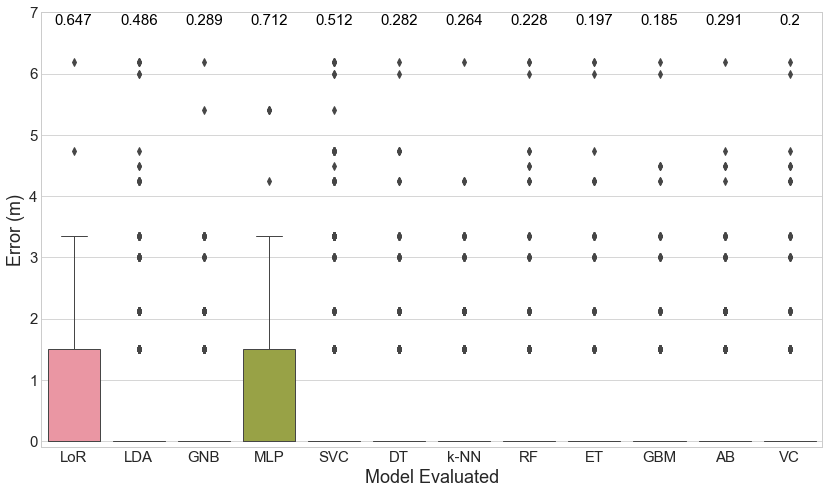

In [24]:
column_boxplot(topDf, 'error', 'error_results_boxplot', box_bool = True)

##  Barplot Accuracy por Modelo

Populating the interactive namespace from numpy and matplotlib


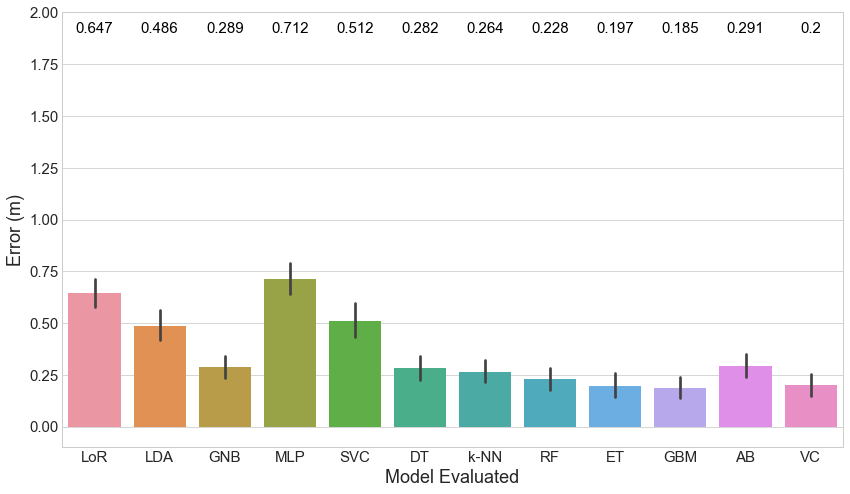

In [26]:
column_boxplot(topDf, 'error', 'error_results_barplot', box_bool = False)

In [27]:
rename_order(topDf)[['Modelo', 'Configuracion', 'Accuracy', 'errorMetrico']]

,Modelo,Configuracion,Accuracy,errorMetrico
0,LoR,"[4, 1, 2, 3, 1]",0.708543,0.647290
1,LDA,"[6, 1, 3, 3, 5]",0.771807,0.486200
2,GNB,"[4, 1, 2, 6, 1]",0.860133,0.288983
3,MLP,"[4, 1, 4, 6, 1]",0.698626,0.711882
4,SVC,"[6, 6, 3, 3, 5]",0.829563,0.511966
5,DT,"[6, 1, 3, 3, 5]",0.852578,0.282129
6,k-NN,"[6, 1, 3, 6, 1]",0.877780,0.264383
7,RF,"[6, 1, 3, 3, 5]",0.898412,0.227890
8,ET,"[6, 1, 3, 3, 5]",0.892472,0.196575
9,GBM,"[6, 1, 3, 3, 5]",0.914520,0.185316


In [28]:
"""
from __future__ import print_function
import tools

import warnings
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
warnings.filterwarnings("ignore", category=DeprecationWarning)

from collections import OrderedDict
from time import time
from plotly.offline.offline import _plot_html
from scipy.stats import randint
from scipy.stats import expon

# from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

This module provides ideas for improving some machine learning algorithms.
"""

def adaboost_param():
    parameters = {
        # 'selector__extraTC__n_estimators': [10],
        # 'selector__extraTC__n_estimators': [10, 15],
        # # 'selector__extraTC__criterion': ['entropy'],
        # 'selector__extraTC__criterion': ['gini', 'entropy'],
        # 'selector__extraTC__n_jobs': [-1],
        # 'selector__pca__svd_solver': ['randomized'],
        #'selector__pca__svd_solver': ['full', 'arpack', 'randomized'],
        # 'selector__pca__whiten': [True],
        #'selector__pca__whiten': [True,False],
        'AdaBoostClassifier__algorithm' : ['SAMME', 'SAMME.R'],
        'AdaBoostClassifier__n_estimators': [50, 100, 500],
        'AdaBoostClassifier__learning_rate': [0.01, 0.1, 1.0, 2.0]
    }
    return parameters

def voting_param():
    parameters = {
        # 'selector__extraTC__n_estimators': [10],
        # 'selector__extraTC__n_estimators': [10, 15],
        # # 'selector__extraTC__criterion': ['entropy'],
        # 'selector__extraTC__criterion': ['gini', 'entropy'],
        # 'selector__extraTC__n_jobs': [-1],
        # 'selector__pca__svd_solver': ['randomized'],
        #'selector__pca__svd_solver': ['full', 'arpack', 'randomized'],
        # 'selector__pca__whiten': [True],
        #'selector__pca__whiten': [True,False],
        'VotingClassifier__voting': ['hard', 'soft']
    }
    return parameters

def gradientboosting_param():
    parameters = {
        # 'selector__extraTC__n_estimators': [10],
        # 'selector__extraTC__n_estimators': [10, 15],
        # # 'selector__extraTC__criterion': ['entropy'],
        # 'selector__extraTC__criterion': ['gini', 'entropy'],
        # 'selector__extraTC__n_jobs': [-1],
        # 'selector__pca__svd_solver': ['randomized'],
        #'selector__pca__svd_solver': ['full', 'arpack', 'randomized'],
        # 'selector__pca__whiten': [True],
        #'selector__pca__whiten': [True,False],
        'GradientBoostingClassifier__n_estimators': [100, 200, 300],
        'GradientBoostingClassifier__max_depth': [3, 6, 9],
        'GradientBoostingClassifier__learning_rate': [0.01, 0.1, 0.3],
        'GradientBoostingClassifier__max_features' : ["sqrt", "log2", None],
        'GradientBoostingClassifier__loss' : ['deviance', 'exponential']
    }
    return parameters

def extratrees_param():       
    parameters = {
        # 'selector__extraTC__n_estimators': [10],
        # 'selector__extraTC__n_estimators': [10, 15],
        # 'selector__extraTC__criterion': ['gini', 'entropy'],
        # # 'selector__extraTC__criterion': ['entropy'],
        # 'selector__extraTC__n_jobs': [-1],
        # 'selector__pca__svd_solver': ['randomized'],
        #'selector__pca__svd_solver': ['full', 'arpack', 'randomized'],
        # 'selector__pca__whiten': [True],
        #'selector__pca__whiten': [True,False],
        'ExtraTreesClassifier__n_estimators': [10, 15, 20],
        'ExtraTreesClassifier__criterion': ['gini', 'entropy'],
        'ExtraTreesClassifier__min_samples_leaf': [1, 2, 3, 4, 5],
        #'ExtraTreesClassifier__min_samples_leaf': range(200,1001,200),
        'ExtraTreesClassifier__max_leaf_nodes': [3, 5, 7, 9],
        'ExtraTreesClassifier__max_depth': [2, 3, 4, 5],
        'ExtraTreesClassifier__max_features' : [None, 'sqrt', 'log2'],
        'ExtraTreesClassifier__class_weight' : ['balanced_subsample', None, 'balanced']
    }
    return parameters

def randomforest_param():
    parameters = {
        # 'selector__extraTC__n_estimators': [10],
        # 'selector__extraTC__n_estimators': [10, 15],
        # # 'selector__extraTC__criterion': ['entropy'],
        # 'selector__extraTC__criterion': ['gini', 'entropy'],
        # 'selector__extraTC__n_jobs': [-1],
        # 'selector__pca__svd_solver': ['randomized'],
        #'selector__pca__svd_solver': ['full', 'arpack', 'randomized'],
        # 'selector__pca__whiten': [True],
        #'selector__pca__whiten': [True,False],
        'RandomForestClassifier__n_estimators': [5, 10, 15, 30],
        'RandomForestClassifier__criterion': ['gini', 'entropy'],
        'RandomForestClassifier__warm_start': [True,False],
        'RandomForestClassifier__max_features' : [None, 'sqrt', 'log2'],
        # 'RandomForestClassifier__min_samples_leaf': [1,2,3,4,5],
        # 'RandomForestClassifier__max_leaf_nodes': [2,3,4,5],
        'RandomForestClassifier__class_weight' : ['balanced_subsample', None, 'balanced'],
        'RandomForestClassifier__max_depth': [2, 5, 10, 20]
    }    
    return parameters

def decisiontree_param():
    parameters = {
        # 'selector__extraTC__n_estimators':  [10],
        # 'selector__extraTC__n_estimators':  [10, 15],
        # # 'selector__extraTC__criterion': ['entropy'],
        # 'selector__extraTC__criterion': ['gini','entropy'],
        # 'selector__extraTC__n_jobs': [-1],
        # 'selector__pca__svd_solver': ['randomized'],
        #'selector__pca__svd_solver': ['full', 'arpack', 'randomized'],
        # 'selector__pca__whiten': [True],
        #'selector__pca__whiten': [True,False],
        'DecisionTreeClassifier__criterion': ['gini','entropy'],
        'DecisionTreeClassifier__splitter': ['best','random'],
        'DecisionTreeClassifier__max_features': ['sqrt','log2', None],
        # 'DecisionTreeClassifier__max_leaf_nodes': [2,3, None],
        'DecisionTreeClassifier__class_weight' : [None, 'balanced'],
        'DecisionTreeClassifier__max_depth': [2, 3, 10, 50, 100]
        # 'DecisionTreeClassifier__min_samples_leaf': [1,3,5, None]
    }
    return parameters

def lda_param():
    parameters = {
        # 'selector__extraTC__n_estimators':  [10],
        # 'selector__extraTC__n_estimators':  [10, 15],
        # # 'selector__extraTC__criterion': ['entropy'],
        # 'selector__extraTC__criterion': ['gini','entropy'],
        # 'selector__extraTC__n_jobs': [-1],
        # 'selector__pca__svd_solver': ['randomized'],
        #'selector__pca__svd_solver': ['full', 'arpack', 'randomized'],
        # 'selector__pca__whiten': [True],
        #'selector__pca__whiten': [True,False],
        'LinearDiscriminantAnalysis__solver': ['svd', 'lsqr', 'eigen']
    }
    return parameters

def svc_param():
    parameters = {
        # 'selector__extraTC__n_estimators':  [10],
        # 'selector__extraTC__n_estimators':  [10, 15],
        # # 'selector__extraTC__criterion': ['entropy'],
        # 'selector__extraTC__criterion': ['gini','entropy'],
        # 'selector__extraTC__n_jobs': [-1],
        #'selector__pca__svd_solver': ['full', 'arpack', 'randomized'],
        # 'selector__pca__svd_solver': ['randomized'],
        # 'selector__pca__whiten': [True],
        #'selector__pca__whiten': [True,False],
        'SVC__kernel': ['linear','poly', 'rbf','sigmoid'],
        # 'SVC__kernel': ['rbf'],
        'SVC__C': [1, 10, 25, 50, 100],
        'SVC__decision_function_shape': ['ovo','ovr']
        # 'SVC__decision_function_shape': ['ovr']
    }
    return parameters

def knn_param():
    parameters = {
        # 'selector__extraTC__n_estimators':  [10, 15],
        # # 'selector__extraTC__n_estimators':  [10],
        # 'selector__extraTC__criterion': ['gini','entropy'],
        # 'selector__extraTC__n_jobs': [-1],
        # 'selector__pca__svd_solver': ['randomized'],
        #'selector__pca__svd_solver': ['full', 'arpack', 'randomized'],
        # 'selector__pca__whiten': [True],
        #'selector__pca__whiten': [True,False],
        'KNeighborsClassifier__n_neighbors': [1, 3, 5,7,9,11],
        'KNeighborsClassifier__weights': ['uniform','distance'],
        'KNeighborsClassifier__algorithm': ['ball_tree','kd_tree','brute']
        # 'KNeighborsClassifier__algorithm': ['auto']
    }
    return parameters

def logistic_param():
    parameters = {
        # 'selector__extraTC__n_estimators':  [10],
        # 'selector__extraTC__n_estimators':  [10, 15],
        # 'selector__extraTC__criterion': ['gini','entropy'],
        # 'selector__extraTC__n_jobs': [-1],
        # 'selector__pca__svd_solver': ['randomized'],
        #'selector__pca__svd_solver': ['full', 'arpack', 'randomized'],
        # 'selector__pca__whiten': [True],
        #'selector__pca__whiten': [True,False],
        #'LogisticRegression__penalty': ['l2'], #, 'l1'
        # 'LogisticRegression__solver': ['newton-cg','lbfgs','liblinear','sag'],
        'LogisticRegression__solver': ['newton-cg','lbfgs', 'sag'],
        'LogisticRegression__warm_start': [True,False],        
        'LogisticRegression__multi_class' = ['ovr', 'multinomial'],
        'LogisticRegression__C' = [0.8, 0.9, 1.0, 1.1, 1.2]
    }
    return parameters

def naivebayes_param():
    parameters = {
        # 'selector__extraTC__n_estimators':  [10],
        # 'selector__extraTC__n_estimators':  [10, 15],
        # 'selector__extraTC__criterion': ['gini','entropy'],
        # 'selector__extraTC__n_jobs': [-1],
        #'selector__pca__svd_solver': ['full', 'arpack', 'randomized'],
        # 'selector__pca__whiten': [True],
        #'selector__pca__whiten': [True,False]
        'GaussianNB__priors': [None]
    }
    return parameters

def mlperceptron_param():
    parameters = {
        # 'selector__extraTC__n_estimators':  [10],
        # 'selector__extraTC__n_estimators':  [10, 15],
        # 'selector__extraTC__criterion': ['gini','entropy'],
        # 'selector__extraTC__n_jobs': [-1],
        #'selector__pca__svd_solver': ['full', 'arpack', 'randomized'],
        #'selector__pca__whiten': [True,False],
        'MLPClassifier__hidden_layer_sizes': [10, 20, 50, 100],
        'MLPClassifier__activation': ['identity', 'logistic', 'tanh', 'relu'],
        'MLPClassifier__solver' : ['lbfgs', 'sgd', 'adam'],
        'MLPClassifier__learning_rate' : ['constant', 'invscaling', 'adaptive'],
        'MLPClassifier__alpha' : np.logspace(-5, 3, 5)
    }
    return parameters

def get_params(model):
    if model == 'AdaBoostClassifier':
        return adaboost_param()
    elif model == 'VotingClassifier':
        return voting_param()
    elif model == 'GradientBoostingClassifier':
        return gradientboosting_param()
    elif model == 'ExtraTreesClassifier':
        return extratrees_param()
    elif model == 'RandomForestClassifier':
        return randomforest_param()
    elif model == 'DecisionTreeClassifier':
        return decisiontree_param()
    elif model == 'LinearDiscriminantAnalysis':
        return lda_param()
    elif model == 'SVC':
        return svc_param()
    elif model == 'KNeighborsClassifier':
        return knn_param()
    elif model == 'LogisticRegression':
        return logistic_param()
    elif model == 'GaussianNB':
        return naivebayes_param()
    elif model == 'MLPClassifier':
        return mlperceptron_param()
    return None



In [123]:
### frecuencias
configuracion = set_config() #dict ['name']=configuracion
estimators = set_models() #list (...(name, model))

num_splits = 10
kfold = KFold(n_splits=num_splits, shuffle=False)

lista_reporte = []
lista_df = [0]*12
indice = 0
for name, model in estimators:
    # name, model     # nombre y modelo
    grilla_parametros = get_params(name)   # parametros
    grilla_parametros = dict((key.split(name+'__')[-1], value) for (key,value) in grilla_parametros.items())
    X, y = _createDataset(frecuencias, configuracion[name])
    grid_search_t = GridSearchCV(model, grilla_parametros, n_jobs = -1, verbose=1, cv = kfold)
    print('GridSearch for ',name)
    try:
        grid_search_t.fit(X, y)
        # por diccionario
        reporte = {}
        reporte['modelo'] = name
        reporte['best_score'] = round(grid_search_t.best_score_, 3)
        reporte['fits'] = len(grid_search_t.grid_scores_)*num_splits
        reporte['parametros'] = grid_search_t.best_params_
        lista_reporte.append(reporte)
        # Por dataframe
        dfcv = pd.DataFrame(grid_search_t.cv_results_)
        dfcv['values'] = pd.DataFrame(grid_search_t.grid_scores_)['cv_validation_scores']
        dfcv['Model'] = name
        column_head = ['Model', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'values', 'params']
        dfcv = dfcv[column_head].sort_values('mean_test_score', ascending=False).head(3)
        lista_df[indice] =dfcv

    except:
        lista_reporte.append({})
        lista_df[indice] = 1
    indice = indice + 1

GridSearch for  LogisticRegression
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   59.0s finished


GridSearch for  LinearDiscriminantAnalysis
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


GridSearch for  GaussianNB
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


GridSearch for  MLPClassifier
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   31.0s finished


GridSearch for  SVC
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 37.1min finished


GridSearch for  DecisionTreeClassifier
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished


GridSearch for  KNeighborsClassifier
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   11.5s finished


GridSearch for  RandomForestClassifier
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.8s finished


GridSearch for  ExtraTreesClassifier
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.8s finished


GridSearch for  GradientBoostingClassifier
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  5.8min finished


GridSearch for  AdaBoostClassifier
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.3s finished


GridSearch for  VotingClassifier
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   17.5s finished


In [125]:
pd.DataFrame(lista_reporte)

,best_score,fits,modelo,parametros
0,0.742,60,LogisticRegression,"{'penalty': 'l2', 'solver': 'newton-cg', 'warm..."
1,0.772,10,LinearDiscriminantAnalysis,{'solver': 'svd'}
2,0.860,10,GaussianNB,{'priors': None}
3,0.722,40,MLPClassifier,"{'activation': 'tanh', 'hidden_layer_sizes': 100}"
4,0.830,240,SVC,"{'C': 1, 'decision_function_shape': 'ovo', 'ke..."
5,0.853,120,DecisionTreeClassifier,"{'criterion': 'gini', 'max_features': None, 's..."
6,0.879,240,KNeighborsClassifier,"{'algorithm': 'ball_tree', 'n_neighbors': 5, '..."
7,0.902,80,RandomForestClassifier,"{'criterion': 'gini', 'n_estimators': 15, 'war..."
8,0.903,60,ExtraTreesClassifier,"{'criterion': 'entropy', 'n_estimators': 20}"
9,0.911,180,GradientBoostingClassifier,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."


In [128]:
for i in range(len(lista_df)):
    display(lista_df[i])

,Model,mean_test_score,mean_fit_time,mean_score_time,values,params
0,KNeighborsClassifier,0.741971,18.772897,0.013939,"[0.757641921397, 0.770742358079, 0.72270742358...","{'penalty': 'l2', 'solver': 'newton-cg', 'warm..."
1,KNeighborsClassifier,0.741971,17.768384,0.002044,"[0.757641921397, 0.770742358079, 0.72270742358...","{'penalty': 'l2', 'solver': 'newton-cg', 'warm..."
2,KNeighborsClassifier,0.741752,3.800795,0.001832,"[0.757641921397, 0.770742358079, 0.72270742358...","{'penalty': 'l2', 'solver': 'lbfgs', 'warm_sta..."


,Model,mean_test_score,mean_fit_time,mean_score_time,values,params
0,KNeighborsClassifier,0.771804,0.023598,0.000581,"[0.75495049505, 0.814356435644, 0.769801980198...",{'solver': 'svd'}


,Model,mean_test_score,mean_fit_time,mean_score_time,values,params
0,KNeighborsClassifier,0.86013,0.006,0.001608,"[0.846522781775, 0.879807692308, 0.88942307692...",{'priors': None}


,Model,mean_test_score,mean_fit_time,mean_score_time,values,params
2,KNeighborsClassifier,0.722182,8.162822,0.008504,"[0.73381294964, 0.721153846154, 0.723557692308...","{'activation': 'tanh', 'hidden_layer_sizes': 100}"
1,KNeighborsClassifier,0.711848,9.123837,0.011647,"[0.719424460432, 0.701923076923, 0.71875, 0.69...","{'activation': 'logistic', 'hidden_layer_sizes..."
3,KNeighborsClassifier,0.685172,3.432653,0.002133,"[0.623501199041, 0.704326923077, 0.69230769230...","{'activation': 'relu', 'hidden_layer_sizes': 100}"


,Model,mean_test_score,mean_fit_time,mean_score_time,values,params
2,KNeighborsClassifier,0.829568,1.532580,0.062207,"[0.845588235294, 0.833333333333, 0.78624078624...","{'C': 1, 'decision_function_shape': 'ovo', 'ke..."
6,KNeighborsClassifier,0.829568,1.564960,0.064110,"[0.845588235294, 0.833333333333, 0.78624078624...","{'C': 1, 'decision_function_shape': 'ovr', 'ke..."
10,KNeighborsClassifier,0.822692,1.563478,0.064558,"[0.821078431373, 0.825980392157, 0.77149877149...","{'C': 10, 'decision_function_shape': 'ovo', 'k..."


,Model,mean_test_score,mean_fit_time,mean_score_time,values,params
4,KNeighborsClassifier,0.852577,0.005767,0.000416,"[0.871287128713, 0.858910891089, 0.85891089108...","{'criterion': 'gini', 'max_features': None, 's..."
10,KNeighborsClassifier,0.849851,0.008128,0.000450,"[0.866336633663, 0.85396039604, 0.836633663366...","{'criterion': 'entropy', 'max_features': None,..."
0,KNeighborsClassifier,0.838949,0.005889,0.000716,"[0.834158415842, 0.836633663366, 0.85643564356...","{'criterion': 'gini', 'max_features': 'sqrt', ..."


,Model,mean_test_score,mean_fit_time,mean_score_time,values,params
1,KNeighborsClassifier,0.878758,0.002707,0.014933,"[0.873170731707, 0.867970660147, 0.87286063569...","{'algorithm': 'ball_tree', 'n_neighbors': 5, '..."
9,KNeighborsClassifier,0.878758,0.002894,0.005318,"[0.875609756098, 0.865525672372, 0.87530562347...","{'algorithm': 'kd_tree', 'n_neighbors': 5, 'we..."
8,KNeighborsClassifier,0.877780,0.003017,0.005293,"[0.880487804878, 0.870415647922, 0.86063569682...","{'algorithm': 'kd_tree', 'n_neighbors': 5, 'we..."


,Model,mean_test_score,mean_fit_time,mean_score_time,values,params
2,KNeighborsClassifier,0.902131,0.061748,0.003408,"[0.89603960396, 0.908415841584, 0.913366336634...","{'criterion': 'gini', 'n_estimators': 15, 'war..."
3,KNeighborsClassifier,0.902131,0.062324,0.003501,"[0.89603960396, 0.908415841584, 0.913366336634...","{'criterion': 'gini', 'n_estimators': 15, 'war..."
6,KNeighborsClassifier,0.899901,0.077736,0.003002,"[0.893564356436, 0.898514851485, 0.90841584158...","{'criterion': 'entropy', 'n_estimators': 15, '..."


,Model,mean_test_score,mean_fit_time,mean_score_time,values,params
5,KNeighborsClassifier,0.902874,0.065961,0.003582,"[0.893564356436, 0.886138613861, 0.90099009901...","{'criterion': 'entropy', 'n_estimators': 20}"
2,KNeighborsClassifier,0.902379,0.080650,0.005423,"[0.903465346535, 0.90099009901, 0.893564356436...","{'criterion': 'gini', 'n_estimators': 20}"
1,KNeighborsClassifier,0.900644,0.059870,0.004063,"[0.908415841584, 0.893564356436, 0.89603960396...","{'criterion': 'gini', 'n_estimators': 15}"


,Model,mean_test_score,mean_fit_time,mean_score_time,values,params
0,KNeighborsClassifier,0.911051,12.862864,0.022081,"[0.915841584158, 0.891089108911, 0.91584158415...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
1,KNeighborsClassifier,0.907582,15.775231,0.028561,"[0.913366336634, 0.886138613861, 0.91089108910...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
12,KNeighborsClassifier,0.905600,12.610143,0.022964,"[0.913366336634, 0.881188118812, 0.91336633663...","{'learning_rate': 0.3, 'max_depth': 3, 'n_esti..."


,Model,mean_test_score,mean_fit_time,mean_score_time,values,params
3,KNeighborsClassifier,0.890491,0.960834,0.044224,"[0.890243902439, 0.892420537897, 0.88753056234...","{'learning_rate': 2.0, 'n_estimators': 100}"
1,KNeighborsClassifier,0.886825,1.312772,0.047485,"[0.880487804878, 0.880195599022, 0.88508557457...","{'learning_rate': 1.0, 'n_estimators': 100}"
2,KNeighborsClassifier,0.879492,0.539487,0.023734,"[0.875609756098, 0.877750611247, 0.88019559902...","{'learning_rate': 2.0, 'n_estimators': 50}"


,Model,mean_test_score,mean_fit_time,mean_score_time,values,params
1,KNeighborsClassifier,0.913776,5.590304,0.012158,"[0.913366336634, 0.891089108911, 0.91584158415...",{'voting': 'soft'}
0,KNeighborsClassifier,0.904361,6.529445,0.018439,"[0.915841584158, 0.905940594059, 0.89108910891...",{'voting': 'hard'}
